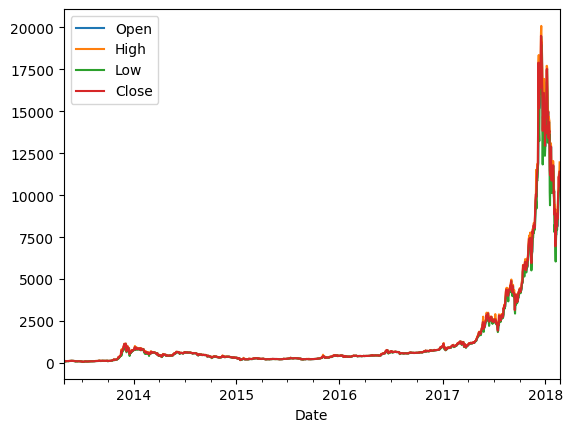

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet
import warnings

#Preberi csv
df = pd.read_csv('./bitcoin.csv',sep=',', decimal='.',parse_dates=[0], index_col=[0])
df.plot()
df.index = pd.to_datetime(df.index, format='%Y/%m/%d') #ce datum ni v ustrezni obliki ga preoblikuj

In [143]:
df_temp = df.resample(rule="D").sum() # preverimo na koliko casa so meritve(sam read_csv to ne prepozna in freq oziroma frequency je Nan, za obdelavo podatkov z forecaster rabimo tisti podatek)
print(df_temp)

                Open      High       Low     Close
Date                                              
2013-04-28    135.30    135.98    132.10    134.21
2013-04-29    134.44    147.49    134.00    144.54
2013-04-30    144.00    146.93    134.05    139.00
2013-05-01    139.00    139.89    107.72    116.99
2013-05-02    116.38    125.60     92.28    105.21
...              ...       ...       ...       ...
2018-02-16  10135.70  10324.10   9824.82  10233.90
2018-02-17  10207.50  11139.50  10149.40  11112.70
2018-02-18  11123.40  11349.80  10326.00  10551.80
2018-02-19  10552.60  11273.80  10513.20  11225.30
2018-02-20  11231.80  11958.50  11231.80  11403.70

[1760 rows x 4 columns]


In [89]:
forecaster = Prophet() #naredimo eno instanco forecaster-ja
horizon = 3 # dolocimo za koliko dni v naprej zelimo napovedovati/ vzamemo toliko dni iz dataframe-a v testnih podatkov
df_date  = df_temp.index # ko date vzamemo samo indeksni stolpec
print(df_date)

DatetimeIndex(['2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01',
               '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05',
               '2013-05-06', '2013-05-07',
               ...
               '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18',
               '2018-02-19', '2018-02-20'],
              dtype='datetime64[ns]', name='Date', length=1760, freq='D')


In [97]:
y_train = df_temp[: -horizon] # ucne podatke so vse vrstice razen najnovesi(dolzino) ki smo dolocili // v nasem primeru 3
y_test = df_temp[-horizon:]

y_train = pd.DataFrame(y_train, columns =['Open','High','Low','Close'])
y_test = pd.DataFrame(y_test, columns= ['Open','High','Low','Close'])
y_test.tail(3)



,Open,High,Low,Close
Date,,,,
2018-02-18,11123.4,11349.8,10326.0,10551.8
2018-02-19,10552.6,11273.8,10513.2,11225.3
2018-02-20,11231.8,11958.5,11231.8,11403.7


In [91]:
forecaster.fit(y_train) # ucimo model na učne podatke

22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:05 - cmdstanpy - INFO - Chain [1] done processing
22:59:05 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing
22:59:06 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet()

In [98]:
fh = ForecastingHorizon(y_test.index, is_relative=False) # določimo za katere podatke bomo testirali

In [137]:
y_pred = forecaster.predict(fh) # testiramo model // predict values 
y_pred= y_pred.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

open_results = []
high_results = []
close_results = []
low_results = []

open_true = []
high_true = []
close_true = []
low_true = []

for val in y_pred['Open']:
    open_results.append(val)
for val in y_pred['High']:
    high_results.append(val)
for val in y_pred['Low']:
    low_results.append(val)
for val in y_pred['Close']:
    close_results.append(val)

for val in y_test['Open']:
    open_true.append(val)
for val in y_test['High']:
    high_true.append(val)
for val in y_test['Low']:
    low_true.append(val)
for val in y_test['Close']:
    close_true.append(val)
#print(open_results)
print(open_results,open_true)

[11699.285595484147, 11766.77264533674, 11851.35236264869] [11123.4, 10552.6, 11231.8]


In [138]:
#ci = forecaster.predict_interval(fh,coverage=0.9)
#ci

#Izpišemo absolutno napako za vsako vrstico ki smo jo napovedali
print("MAE - open: ",metrics.mean_absolute_error(open_results,open_true)) 
print("MAE - close: ",metrics.mean_absolute_error(close_results,close_true))
print("MAE - high: ",metrics.mean_absolute_error(high_results,high_true))
print("MAE - low: ",metrics.mean_absolute_error(low_results,low_true))

MAE - open:  803.203534489859
MAE - close:  810.4245188991378
MAE - high:  865.7077677298233
MAE - low:  465.7821976982941
